In [2]:
import torch
from transformers import AutoModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc
import torch.nn.functional as f

# Вначале для удобства лучше все тестировать на 70M модели,
# но для итоговой презентации наверное нужно будет все прогнать на 2.7 B модели
model_name = "EleutherAI/pythia-410M"

checkpoint_steps = [0] + [2**i for i in range(1, 10)] + list(range(1000, 143001, 1000))
branch_names = [f"step{step}" for step in checkpoint_steps]

# Посмотрим как выглядит архитектура модели и как её доставать
model = AutoModel.from_pretrained(model_name, revision=branch_names[-1], trust_remote_code=True)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPTNeoXModel(
  (embed_in): Embedding(50304, 1024)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-23): 24 x GPTNeoXLayer(
      (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (post_attention_dropout): Dropout(p=0.0, inplace=False)
      (post_mlp_dropout): Dropout(p=0.0, inplace=False)
      (attention): GPTNeoXSdpaAttention(
        (rotary_emb): GPTNeoXRotaryEmbedding()
        (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
      )
      (mlp): GPTNeoXMLP(
        (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
        (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELUActivation()
      )
    )
  )
  (final_layer_n

In [3]:
sigma_up_dict_std = {layer_idx: [] for layer_idx in range(24)}
sigma_down_dict_std = {layer_idx: [] for layer_idx in range(24)}
sigma_up_dict_mean = {layer_idx: [] for layer_idx in range(24)}
sigma_down_dict_mean = {layer_idx: [] for layer_idx in range(24)}

for branch in tqdm(branch_names[::7], desc="Processing checkpoints"):
    try:
        model = AutoModel.from_pretrained(model_name, revision=branch, trust_remote_code=True)

        for layer_idx, layer in enumerate(model.layers):
            mlp = layer.mlp
            up = mlp.dense_h_to_4h.weight.detach()
            down = mlp.dense_4h_to_h.weight.detach().T
            up = f.normalize(up, p=2, dim=1)
            down = f.normalize(down, p=2, dim=1)

            sigma_up = up@up.T
            sigma_down = down@down.T
            array_up = []
            array_down = []

            d, d = sigma_up.shape
            for i in range(0, d, 13):
                for j in range(0, d, 13):
                    if i < j:
                        array_up.append(((1/np.pi)*180*torch.arccos(sigma_up[i][j])).item())
                        array_down.append(((1/np.pi)*180*torch.arccos(sigma_down[i][j])).item())

            sigma_up_dict_std[layer_idx].append(np.std(array_up))
            sigma_down_dict_std[layer_idx].append(np.std(array_down))
            sigma_up_dict_mean[layer_idx].append(np.mean(array_up))
            sigma_down_dict_mean[layer_idx].append(np.mean(array_down))

    except Exception as e:
        print(f"Error processing {branch}: {e}")
    finally:
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

Processing checkpoints:  64%|██████▎   | 14/22 [21:30<11:50, 88.79s/it]

pytorch_model.bin:   6%|5         | 52.4M/911M [00:00<?, ?B/s]

Processing checkpoints:  68%|██████▊   | 15/22 [23:13<10:51, 93.13s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

Processing checkpoints:  73%|███████▎  | 16/22 [24:58<09:39, 96.50s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

Processing checkpoints:  77%|███████▋  | 17/22 [26:41<08:13, 98.66s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

Processing checkpoints:  82%|████████▏ | 18/22 [28:19<06:33, 98.44s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

Processing checkpoints:  86%|████████▋ | 19/22 [30:00<04:57, 99.18s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

Processing checkpoints:  95%|█████████▌| 21/22 [33:22<01:39, 99.52s/it] 

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

Processing checkpoints: 100%|██████████| 22/22 [35:09<00:00, 95.87s/it] 


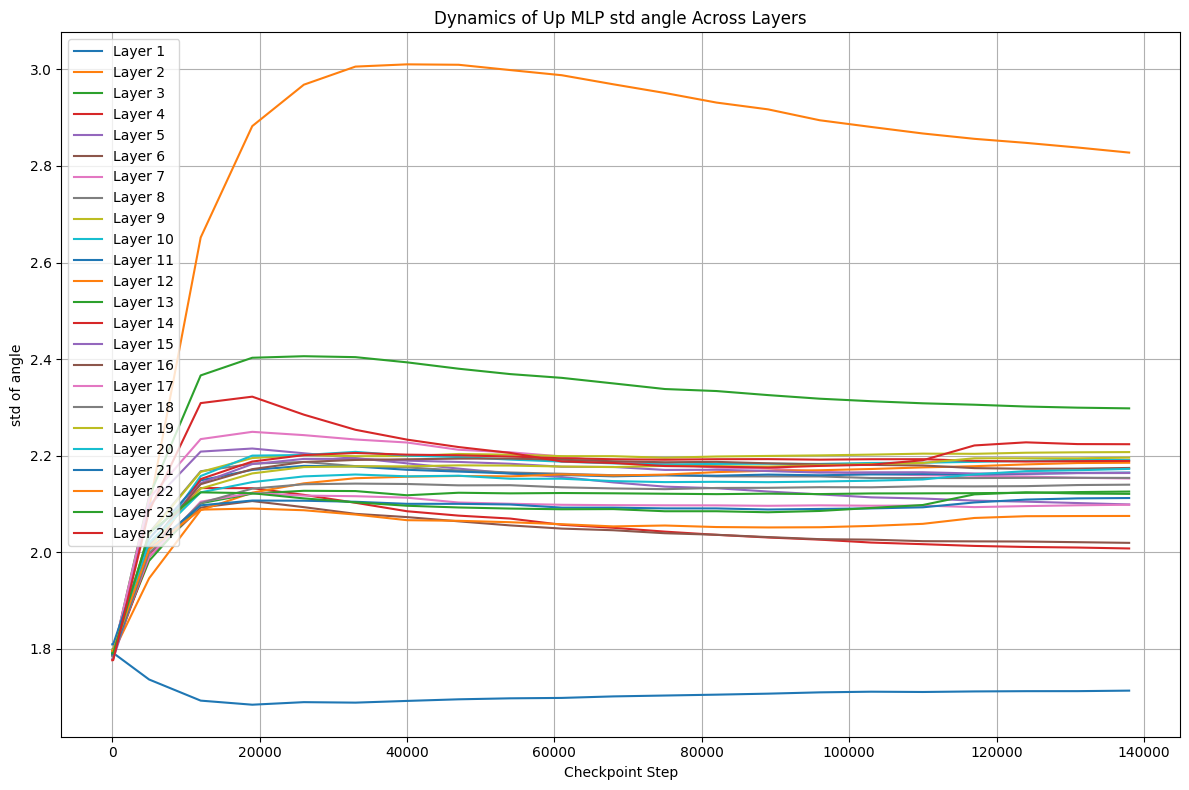

In [10]:
# Построение графика
plt.figure(figsize=(12, 8))
steps = checkpoint_steps[::7]

for layer_idx in range(24):
    plt.plot(steps, sigma_up_dict_std[layer_idx], label=f'Layer {layer_idx + 1}')

plt.xlabel('Checkpoint Step')
plt.ylabel('std of angle')
plt.title('Dynamics of Up MLP std angle Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
sigma_up_dict_std[1][-1]

2.827722474479514

In [13]:
sigma_up_dict_std[0][-1]

1.7136180712164824

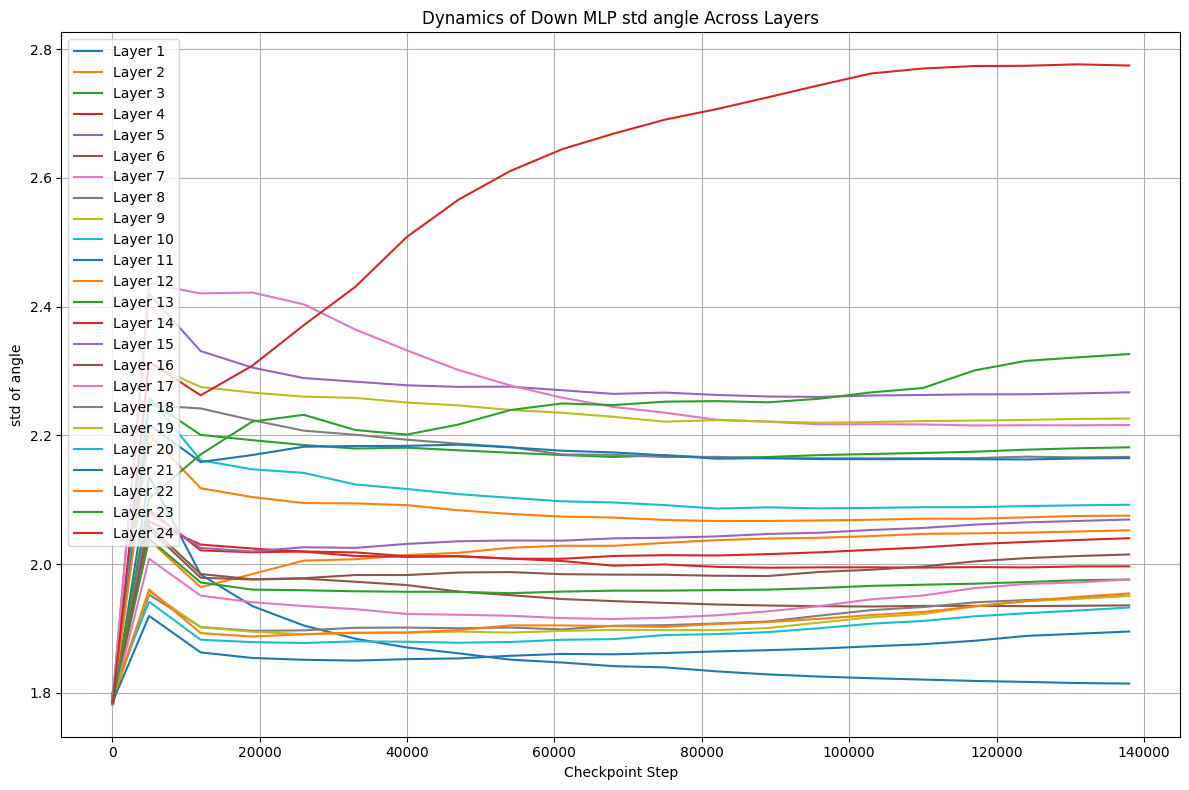

In [18]:
# Построение графика
plt.figure(figsize=(12, 8))
steps = checkpoint_steps[::7]

for layer_idx in range(24):
    plt.plot(steps, sigma_down_dict_std[layer_idx], label=f'Layer {layer_idx + 1}')

plt.xlabel('Checkpoint Step')
plt.ylabel('std of angle')
plt.title('Dynamics of Down MLP std angle Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

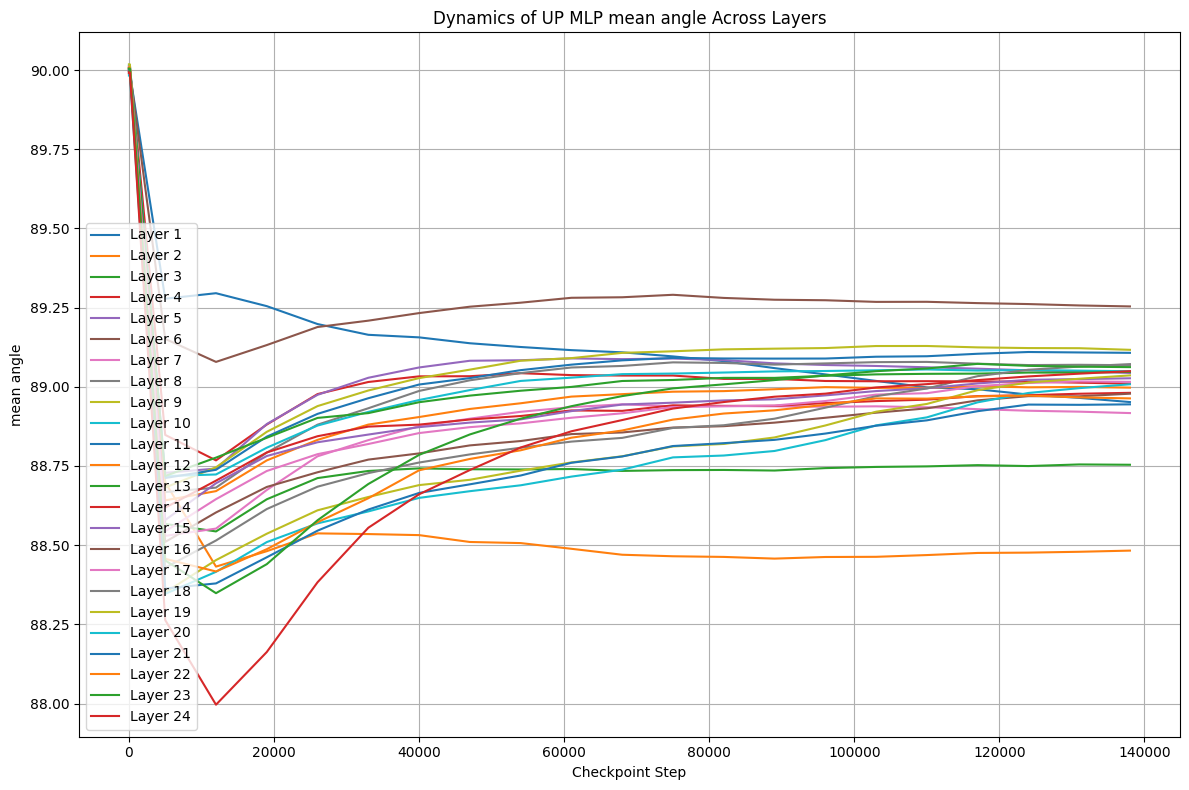

In [16]:
# Построение графика
plt.figure(figsize=(12, 8))
steps = checkpoint_steps[::7]

for layer_idx in range(24):
    plt.plot(steps, sigma_up_dict_mean[layer_idx], label=f'Layer {layer_idx + 1}')

plt.xlabel('Checkpoint Step')
plt.ylabel('mean angle')
plt.title('Dynamics of Up MLP mean angle Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

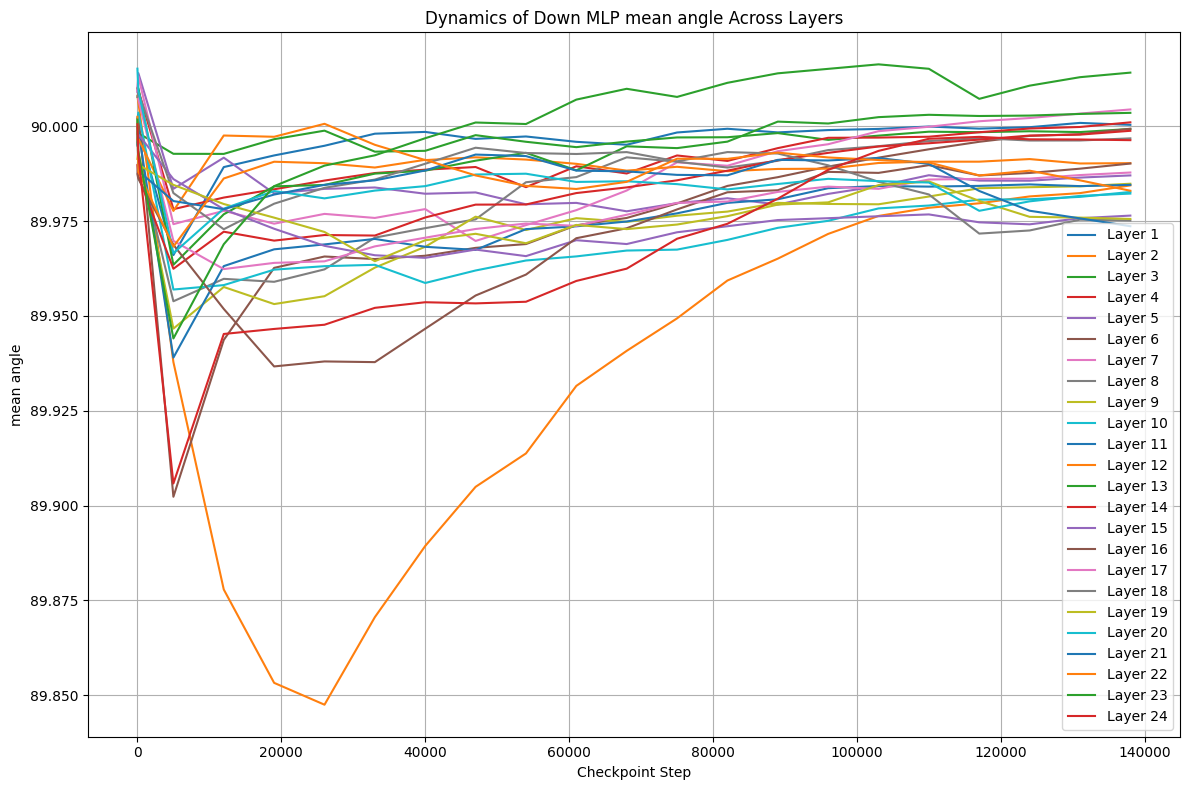

In [8]:
# Построение графика
plt.figure(figsize=(12, 8))
steps = checkpoint_steps[::7]

for layer_idx in range(24):
    plt.plot(steps, sigma_down_dict_mean[layer_idx], label=f'Layer {layer_idx + 1}')

plt.xlabel('Checkpoint Step')
plt.ylabel('mean angle')
plt.title('Dynamics of Down MLP mean angle Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()